In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [2]:
# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'RELATIONAL' : {'cond':['match','relation']}
}

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "../HCPProject/hcp_task"


subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



In [5]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [6]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  taskey = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{taskey}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [7]:
my_exp = 'RELATIONAL'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 232)


In [8]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [9]:
my_exp = 'RELATIONAL'
my_regions = [*range(360)]

In [20]:
HCP_DATA_FRAME = pd.read_excel("../HCPProject/HCP_Behavioral_2.0_original.xlsx")

In [21]:
new_df = HCP_DATA_FRAME[['Subject','Age', 'Gender', 'PMAT24_A_CR']]
new_df.to_csv("HCP_DATA_FILTERED.csv", index = False)

In [22]:
def transform_group(age):
    if age == '22-25':
        return 1
    
    if age == '26-30':
        return 2
    
    if age == '31-35':
        return 3

### Visualize some of the data

(360, 232)
[[array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58]), array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106]), array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180])], [array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33]), array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132]), array([184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206])]]
2
3
(360, 23)


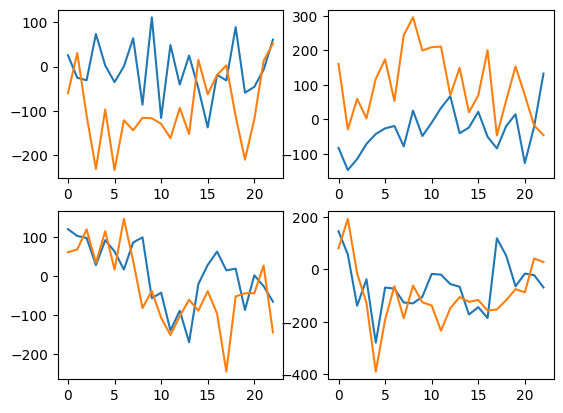

In [23]:
print(data.shape)
print(evs)
print(len(evs))
print(len(evs[0]))

print(data[:,evs[0][0]].shape)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(data[[164, 344],:][:,evs[0][0]].T)
axs[0, 1].plot(data[[164, 344],:][:,evs[0][1]].T)
axs[1, 0].plot(data[[164, 344],:][:,evs[1][0]].T)
axs[1, 1].plot(data[[164, 344],:][:,evs[1][1]].T)
plt.show()

In [44]:
def load_data(my_exp , my_regions):

  HCP_data_frame = pd.read_csv("HCP_DATA_FILTERED.csv")
  HCP_data_frame['age_group'] = HCP_data_frame['Age'].apply(transform_group)

  steps = int(10/TR+.5)    # calculating stpes for 10 seconds

  # las ROI's 
  timeseries_list = []
  # relmatch
  relmatch_list = [] # relation or match

  # age
  age_list = []
  # IQ  
  fluid_intelligence_list = []
  # gender
  Gender_list = []

  order = torch.randperm(100).numpy()
  for i in order:     # subject
    for r in range(2):     # run

      data = load_single_timeseries(subject=subjects[i],
                                    experiment=my_exp,
                                    run=r,
                                    remove_mean=True)

      # Normalizing data by subject
      timeseries = (data - data.mean()) / data.std()

      # get the evs plus 10 seconds of the time series before and after (14 steps for tr=.76)
      evs = load_evs(subject=subjects[i], experiment=my_exp, run=r)

      for c in range(2):   # condition
        for t in range(2): # block
          evs_index = np.hstack((
            np.arange(evs[c][t][0]-steps,evs[c][t][0]),
            np.array(evs[c][t]),
            np.arange((evs[c][t][-1]+1),(evs[c][t][-1]+1+steps))
          ))

          # (N, L, H_in)

          timeseries_list.append(timeseries[my_regions,:][:,evs_index].T)
          relmatch_list.append(c)
          ## control variables
          filtered = HCP_data_frame[HCP_data_frame['Subject'] == int(subjects[i])]
          if len(filtered) > 0:
            age_list.append(HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['age_group'])
            fluid_intelligence_list.append(HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['PMAT24_A_CR'])
            Gender_list.append(1 if HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['Gender'].item()=='F' else 0)
          # else: 
          #   age_list.append(None)
          #   fluid_intelligence_list.append(None)
          #   Gender_list.append(None)
            

  #print(age_list)
  return (
      torch.tensor(np.array(timeseries_list)),
      torch.tensor(np.array(relmatch_list)),
      torch.tensor(np.array(age_list)),#.squeeze(1),
      torch.tensor(np.array(fluid_intelligence_list)).squeeze(1),
      torch.tensor(np.array(Gender_list))
  )

In [45]:
experiment='RELATIONAL'
regions = [*range(360)]
load_data(experiment, regions)

(tensor([[[ 0.1967, -0.8917, -0.2562,  ...,  2.1369,  1.1279, -0.1021],
          [ 0.7728, -0.4538,  0.1204,  ...,  0.0439,  1.5792,  0.5249],
          [ 1.0394,  0.1113,  0.5323,  ...,  0.9128,  1.8699,  0.1258],
          ...,
          [-1.0948, -1.0046,  1.1038,  ...,  0.1009,  0.1787,  1.8431],
          [-0.9940,  0.7377,  1.4904,  ..., -0.1330, -0.1676,  0.3213],
          [-1.6895,  0.2373,  1.0391,  ..., -0.2429, -1.4223,  0.0569]],
 
         [[ 1.0181,  0.8989,  0.5268,  ..., -1.5435,  0.5673,  0.7727],
          [ 0.3172, -0.1180, -0.0567,  ...,  0.8759,  0.3884, -0.8123],
          [ 0.8020, -0.1439, -0.1228,  ..., -0.9793, -0.4808, -0.0949],
          ...,
          [-1.1790,  0.8754,  0.3317,  ...,  1.2267, -0.6981,  0.1754],
          [-1.0637,  0.8072,  0.6731,  ...,  0.5331,  0.0645,  0.0840],
          [-2.0593,  0.5094,  0.1429,  ...,  1.3911, -1.2561, -1.6990]],
 
         [[-0.8678,  0.6992, -1.3900,  ...,  0.3306, -1.8682, -0.7103],
          [-0.7037, -0.7581,

In [30]:
i = 0
HCP_data_frame = HCP_DATA_FRAME
print(HCP_data_frame[HCP_data_frame['Subject'] == subjects[i]])

Empty DataFrame
Columns: [Subject, Release, Acquisition, Gender, Age, 3T_Full_MR_Compl, T1_Count, T2_Count, 3T_RS-fMRI_Count, 3T_RS-fMRI_PctCompl, 3T_Full_Task_fMRI, 3T_tMRI_PctCompl, fMRI_WM_PctCompl, fMRI_Gamb_PctCompl, fMRI_Mot_PctCompl, fMRI_Lang_PctCompl, fMRI_Soc_PctCompl, fMRI_Rel_PctCompl, fMRI_Emo_PctCompl, 3T_dMRI_Compl, 3T_dMRI_PctCompl, dMRI_3T_ReconVrs, fMRI_3T_ReconVrs, 7T_Full_MR_Compl, 7T_RS-fMRI_Count, 7T_RS-fMRI_PctCompl, 7T_Full_Task_fMRI, 7T_tMRI_PctCompl, fMRI_Movie_Compl, fMRI_Movie_PctCompl, fMRI_Ret_Compl, fMRI_Ret_PctCompl, 7T_dMRI_Compl, 7T_dMRI_PctCompl, 7T_fMRI_Mov_Vrs, MEG_AnyData, MEG_FullProt_Compl, MEG_HeadModel_Avail, MEG_CortRibn_Avail, MEG_Anatomy_Avail, MEG_Anatomy_Compl, MEG_Noise_Avail, MEG_Noise_Compl, MEG_RS_Avail, MEG_RS_Compl, MEG_WM_Avail, MEG_WM_Compl, MEG_StoryMath_Avail, MEG_StoryMath_Compl, MEG_Motor_Avail, MEG_Motor_Compl, Non-TB_Compl, VisProc_Compl, DelDisc_Compl, SCPT_Compl, IWRD_Compl, PMAT_Compl, VSPLOT_Compl, EmoRecog_Compl, NEO-FFI

In [31]:
HCP_DATA_FRAME['Subject']

0      100206
1      100610
2      101006
3      101309
4      101915
        ...  
334    966975
335    984472
336    987983
337    993675
338    994273
Name: Subject, Length: 339, dtype: int64